# Telecom Churn Prediction

# Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

#### Below steps will be folowed for evaluation
1. Loading dependencies & datasets

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [74]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [75]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score, accuracy_score
from sklearn import metrics
#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Class Imbalance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

#Others
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Markdown, display ,HTML
import itertools

%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

### Derived attribute related functions

In [76]:
#The above data is with respect to data recharge
# We can create new column indicating data recharge and substitute null columns with 0 value


def create_data_rechange_info(df):
    df['data_rechange_6'] = df['date_of_last_rech_data_6'].isnull()
    df['data_rechange_7'] = df['date_of_last_rech_data_7'].isnull()
    df['data_rechange_8'] = df['date_of_last_rech_data_8'].isnull()

    del df['date_of_last_rech_data_6']
    del df['date_of_last_rech_data_7']
    del df['date_of_last_rech_data_8']

    df_len = len(df)*0.7
    i=0
    for col in df.columns:
        if df[col].isnull().sum() >= df_len:
            df[col].fillna(0, inplace=True)
    return df

def create_last_rechange_days(df):
    df['last_recharge_days'] = (pd.to_datetime('2014-08-31') - df[['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']].apply(pd.to_datetime).max(axis=1)).dt.days
    del df['date_of_last_rech_6']
    del df['date_of_last_rech_7']
    del df['date_of_last_rech_8']
    return df

def create_new_variables(df):
    df = create_data_rechange_info(df)
    df = create_last_rechange_days(df)
    return df

In [77]:
## Set display limits
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [78]:
def observation_log(string):
    display(Markdown("#### <span style='color:blue'>Observation :- </span><br>" +string))

In [79]:
#COMMENT THIS SECTION INCASE RUNNING THIS NOTEBOOK LOCALLY

#Checking the kaggle paths for the uploaded datasets
#import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [80]:
#INCASE RUNNING THIS LOCALLY, PASS THE RELATIVE PATH OF THE CSV FILES BELOW
#(e.g. if files are in same folder as notebook, simple write "train.csv" as path)

# data = pd.read_csv("/kaggle/input/telecom-churn-case-study-hackathon-c53/train.csv")
# unseen = pd.read_csv("/kaggle/input/telecom-churn-case-study-hackathon-c53/test.csv")
# sample = pd.read_csv("/kaggle/input/telecom-churn-case-study-hackathon-c53/sample.csv")
# data_dict = pd.read_csv("/kaggle/input/telecom-churn-case-study-hackathon-c53/data_dictionary.csv")

data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")


print('Train data shape - ',data.shape)
print('Test data shape - ',unseen.shape)
print('Sample data shape - ',sample.shape)
print('Data dictionary shape - ', data_dict.shape)

Train data shape -  (69999, 172)
Test data shape -  (30000, 171)
Sample data shape -  (30000, 2)
Data dictionary shape -  (36, 2)


In [81]:
data.describe()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000

### Check data type of columns

In [82]:
data.info()
# data type are correctly assigned

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 172 entries, id to churn_probability
dtypes: float64(135), int64(28), object(9)
memory usage: 91.9+ MB


### Columns with NULL value

In [83]:
## Columns with Null values
filtered_data = data.loc[:, data.isnull().sum() != 0]
filtered_data.isnull().sum()

loc_og_t2o_mou                702
std_og_t2o_mou                702
loc_ic_t2o_mou                702
last_date_of_month_7          399
last_date_of_month_8          733
onnet_mou_6                  2768
onnet_mou_7                  2687
onnet_mou_8                  3703
offnet_mou_6                 2768
offnet_mou_7                 2687
offnet_mou_8                 3703
roam_ic_mou_6                2768
roam_ic_mou_7                2687
roam_ic_mou_8                3703
roam_og_mou_6                2768
roam_og_mou_7                2687
roam_og_mou_8                3703
loc_og_t2t_mou_6             2768
loc_og_t2t_mou_7             2687
loc_og_t2t_mou_8             3703
loc_og_t2m_mou_6             2768
loc_og_t2m_mou_7             2687
loc_og_t2m_mou_8             3703
loc_og_t2f_mou_6             2768
loc_og_t2f_mou_7             2687
loc_og_t2f_mou_8             3703
loc_og_t2c_mou_6             2768
loc_og_t2c_mou_7             2687
loc_og_t2c_mou_8             3703
loc_og_mou_6  

## 2. Data cleaning and formatting

### Removing columns with more than 70 % null values

In [84]:
df_len = len(data)*0.7
i=0
print('Columns with more than 70% missing values')
for col in data.columns:
    if data[col].isnull().sum() >= df_len:
        i=i+1
        print(i,'.', col,'.',data[col].isnull().sum(),'.', round((data[col].isnull().sum()/len(data))*100,2))
        #del data[col]

Columns with more than 70% missing values
1 . date_of_last_rech_data_6 . 52431 . 74.9
2 . date_of_last_rech_data_7 . 52134 . 74.48
3 . date_of_last_rech_data_8 . 51582 . 73.69
4 . total_rech_data_6 . 52431 . 74.9
5 . total_rech_data_7 . 52134 . 74.48
6 . total_rech_data_8 . 51582 . 73.69
7 . max_rech_data_6 . 52431 . 74.9
8 . max_rech_data_7 . 52134 . 74.48
9 . max_rech_data_8 . 51582 . 73.69
10 . count_rech_2g_6 . 52431 . 74.9
11 . count_rech_2g_7 . 52134 . 74.48
12 . count_rech_2g_8 . 51582 . 73.69
13 . count_rech_3g_6 . 52431 . 74.9
14 . count_rech_3g_7 . 52134 . 74.48
15 . count_rech_3g_8 . 51582 . 73.69
16 . av_rech_amt_data_6 . 52431 . 74.9
17 . av_rech_amt_data_7 . 52134 . 74.48
18 . av_rech_amt_data_8 . 51582 . 73.69
19 . arpu_3g_6 . 52431 . 74.9
20 . arpu_3g_7 . 52134 . 74.48
21 . arpu_3g_8 . 51582 . 73.69
22 . arpu_2g_6 . 52431 . 74.9
23 . arpu_2g_7 . 52134 . 74.48
24 . arpu_2g_8 . 51582 . 73.69
25 . night_pck_user_6 . 52431 . 74.9
26 . night_pck_user_7 . 52134 . 74.48
27 . n

#### <span style="color:blue">Observation :-</span>
Since same count of data for rechange related columns are missing, hence will not delete it. 
Will handle in derived data section.Create new attribute to indicate has data recharge or not and consider default value for NA cell as Zero.

In [85]:
data = create_data_rechange_info(data)
unseen = create_data_rechange_info(unseen)

### Filter High Value customer
 - Those who have recharged with an amount more than or equal 70th percentile of the average recharge amount in the first two months (the good phase)

In [86]:
print("Before High Value customer removal")
data.shape

Before High Value customer removal


(69999, 172)

In [87]:
# calculate the total data recharge amount for June and July --> number of recharges * average recharge amount
data['total_data_rech_6'] = data.total_rech_data_6 * data.av_rech_amt_data_6
data['total_data_rech_7'] = data.total_rech_data_7 * data.av_rech_amt_data_7

unseen['total_data_rech_6'] = unseen.total_rech_data_6 * unseen.av_rech_amt_data_6
unseen['total_data_rech_7'] = unseen.total_rech_data_7 * unseen.av_rech_amt_data_7

In [88]:
# calculate total recharge amount for June and July --> call recharge amount + data recharge amount

#Training data
data['amt_data_6'] = data.total_rech_amt_6 + data.total_data_rech_6
data['amt_data_7'] = data.total_rech_amt_7 + data.total_data_rech_7

#Unseen data
unseen['amt_data_6'] = unseen.total_rech_amt_6 + unseen.total_data_rech_6
unseen['amt_data_7'] = unseen.total_rech_amt_7 + unseen.total_data_rech_7

In [89]:
# Training data
data['av_amt_data_6_7'] = (data.amt_data_6 + data.amt_data_7)/2

# Unseen data
unseen['av_amt_data_6_7'] = (unseen.amt_data_6 + unseen.amt_data_7)/2

In [90]:
#Filtering based HIGH VALUED CUSTOMERS based on (Average_rech_amt_6n7 >= 70th percentile of Average_rech_amt_6n7)
data=data[(data['av_amt_data_6_7']>= data['av_amt_data_6_7'].quantile(0.7))]

#Unseen
#We will not filter unseen data

In [91]:
print("After High Value customer removal")
data.shape

After High Value customer removal


(21013, 177)

### Delete columns with only one value

In [92]:
df_len = len(data)*0.9
i=0
for col in data.columns:
    if len(data[col].value_counts()) == 1:
        i=i+1
        print(i,'.', col,'.',round(data[col].value_counts().iloc[0]*100/len(data),2),'%')
        del data[col]

1 . circle_id . 100.0 %
2 . loc_og_t2o_mou . 99.21 %
3 . std_og_t2o_mou . 99.21 %
4 . loc_ic_t2o_mou . 99.21 %
5 . last_date_of_month_6 . 100.0 %
6 . last_date_of_month_7 . 99.93 %
7 . last_date_of_month_8 . 99.47 %
8 . std_og_t2c_mou_6 . 98.11 %
9 . std_og_t2c_mou_7 . 98.13 %
10 . std_og_t2c_mou_8 . 96.09 %
11 . std_ic_t2o_mou_6 . 98.11 %
12 . std_ic_t2o_mou_7 . 98.13 %
13 . std_ic_t2o_mou_8 . 96.09 %


### Delete columns with more than 90% same values

In [93]:
df_len = len(data)*0.95
i=0
l = []
for col in data.columns:
    if data[col].value_counts().iloc[0] >= df_len:
        i=i+1
        print(i,'.', col,'.',data[col].value_counts().iloc[0],'.',round(data[col].value_counts().iloc[0]*100/len(data),2),'%')
        del data[col]

1 . og_others_7 . 20516 . 97.63 %
2 . og_others_8 . 20065 . 95.49 %
3 . night_pck_user_6 . 20736 . 98.68 %
4 . night_pck_user_7 . 20739 . 98.7 %
5 . night_pck_user_8 . 20773 . 98.86 %


### Removing columns not required for analysis

In [94]:
del data['id'] # primary key

### Check for duplicates

In [95]:
data[data.duplicated()]

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,data_rechange_6,data_rechange_7,data_rechange_8,total_data_rech_6,total_data_rech_7,amt_data_6,amt_data_7,av_amt_data_6_7


In [96]:
data.shape

(21013, 158)

### Remove rows with more than 50% missing values

In [97]:
# Count the rows having more than 50% missing values
df_missing_rows_50 = data[(data.isnull().sum(axis=1)) > (len(data.columns)//2)]
print('DF shape with more than 50% missing values in row -',df_missing_rows_50.shape)
data = data.drop(df_missing_rows_50.index)
print('DF shape post dropping above mentioned rows -',data.shape)

DF shape with more than 50% missing values in row - (14, 158)
DF shape post dropping above mentioned rows - (20999, 158)


In [98]:
filtered_data = data.loc[:, data.isnull().sum() != 0]
filtered_data.isnull().sum()

onnet_mou_6            383
onnet_mou_7            379
onnet_mou_8            808
offnet_mou_6           383
offnet_mou_7           379
offnet_mou_8           808
roam_ic_mou_6          383
roam_ic_mou_7          379
roam_ic_mou_8          808
roam_og_mou_6          383
roam_og_mou_7          379
roam_og_mou_8          808
loc_og_t2t_mou_6       383
loc_og_t2t_mou_7       379
loc_og_t2t_mou_8       808
loc_og_t2m_mou_6       383
loc_og_t2m_mou_7       379
loc_og_t2m_mou_8       808
loc_og_t2f_mou_6       383
loc_og_t2f_mou_7       379
loc_og_t2f_mou_8       808
loc_og_t2c_mou_6       383
loc_og_t2c_mou_7       379
loc_og_t2c_mou_8       808
loc_og_mou_6           383
loc_og_mou_7           379
loc_og_mou_8           808
std_og_t2t_mou_6       383
std_og_t2t_mou_7       379
std_og_t2t_mou_8       808
std_og_t2m_mou_6       383
std_og_t2m_mou_7       379
std_og_t2m_mou_8       808
std_og_t2f_mou_6       383
std_og_t2f_mou_7       379
std_og_t2f_mou_8       808
std_og_mou_6           383
s

#### <span style="color:blue">Observation :-</span>
Since same number of values missin for all mou 6, 7, 8, and it is not dependent on recharge hence,
these rows can be deleted

In [99]:
for col in data.filter(like='mou').columns.tolist():
    data = data[~data[col].isnull()]

### Derived attributes

### Derive last recharge in days from dates

In [100]:
data = create_last_rechange_days(data)
unseen = create_last_rechange_days(unseen)

In [101]:
## Columns with Null values
filtered_data = data.loc[:, data.isnull().sum() != 0]
filtered_data.isnull().sum()

Series([], dtype: float64)

In [102]:
data['churn_probability'].value_counts()

churn_probability
0    18821
1     1129
Name: count, dtype: int64

### Calculate difference detween 8th month and 7th + 6th month

In [103]:
# Train data
data['arpu_diff'] = data.arpu_8 - ((data.arpu_6 + data.arpu_7)/2)

data['onnet_mou_diff'] = data.onnet_mou_8 - ((data.onnet_mou_6 + data.onnet_mou_7)/2)

data['offnet_mou_diff'] = data.offnet_mou_8 - ((data.offnet_mou_6 + data.offnet_mou_7)/2)

data['roam_ic_mou_diff'] = data.roam_ic_mou_8 - ((data.roam_ic_mou_6 + data.roam_ic_mou_7)/2)

data['roam_og_mou_diff'] = data.roam_og_mou_8 - ((data.roam_og_mou_6 + data.roam_og_mou_7)/2)

data['loc_og_mou_diff'] = data.loc_og_mou_8 - ((data.loc_og_mou_6 + data.loc_og_mou_7)/2)

data['std_og_mou_diff'] = data.std_og_mou_8 - ((data.std_og_mou_6 + data.std_og_mou_7)/2)

#data['isd_og_mou_diff'] = data.isd_og_mou_8 - ((data.isd_og_mou_6 + data.isd_og_mou_7)/2)

data['spl_og_mou_diff'] = data.spl_og_mou_8 - ((data.spl_og_mou_6 + data.spl_og_mou_7)/2)

data['total_og_mou_diff'] = data.total_og_mou_8 - ((data.total_og_mou_6 + data.total_og_mou_7)/2)

data['loc_ic_mou_diff'] = data.loc_ic_mou_8 - ((data.loc_ic_mou_6 + data.loc_ic_mou_7)/2)

data['std_ic_mou_diff'] = data.std_ic_mou_8 - ((data.std_ic_mou_6 + data.std_ic_mou_7)/2)

data['isd_ic_mou_diff'] = data.isd_ic_mou_8 - ((data.isd_ic_mou_6 + data.isd_ic_mou_7)/2)

data['spl_ic_mou_diff'] = data.spl_ic_mou_8 - ((data.spl_ic_mou_6 + data.spl_ic_mou_7)/2)

data['total_ic_mou_diff'] = data.total_ic_mou_8 - ((data.total_ic_mou_6 + data.total_ic_mou_7)/2)

data['total_rech_num_diff'] = data.total_rech_num_8 - ((data.total_rech_num_6 + data.total_rech_num_7)/2)

data['total_rech_amt_diff'] = data.total_rech_amt_8 - ((data.total_rech_amt_6 + data.total_rech_amt_7)/2)

data['max_rech_amt_diff'] = data.max_rech_amt_8 - ((data.max_rech_amt_6 + data.max_rech_amt_7)/2)

data['total_rech_data_diff'] = data.total_rech_data_8 - ((data.total_rech_data_6 + data.total_rech_data_7)/2)

data['max_rech_data_diff'] = data.max_rech_data_8 - ((data.max_rech_data_6 + data.max_rech_data_7)/2)

data['av_rech_amt_data_diff'] = data.av_rech_amt_data_8 - ((data.av_rech_amt_data_6 + data.av_rech_amt_data_7)/2)

data['vol_2g_mb_diff'] = data.vol_2g_mb_8 - ((data.vol_2g_mb_6 + data.vol_2g_mb_7)/2)

data['vol_3g_mb_diff'] = data.vol_3g_mb_8 - ((data.vol_3g_mb_6 + data.vol_3g_mb_7)/2)

In [104]:
# Unseen data
unseen['arpu_diff'] = unseen.arpu_8 - ((unseen.arpu_6 + unseen.arpu_7)/2)

unseen['onnet_mou_diff'] = unseen.onnet_mou_8 - ((unseen.onnet_mou_6 + unseen.onnet_mou_7)/2)

unseen['offnet_mou_diff'] = unseen.offnet_mou_8 - ((unseen.offnet_mou_6 + unseen.offnet_mou_7)/2)

unseen['roam_ic_mou_diff'] = unseen.roam_ic_mou_8 - ((unseen.roam_ic_mou_6 + unseen.roam_ic_mou_7)/2)

unseen['roam_og_mou_diff'] = unseen.roam_og_mou_8 - ((unseen.roam_og_mou_6 + unseen.roam_og_mou_7)/2)

unseen['loc_og_mou_diff'] = unseen.loc_og_mou_8 - ((unseen.loc_og_mou_6 + unseen.loc_og_mou_7)/2)

unseen['std_og_mou_diff'] = unseen.std_og_mou_8 - ((unseen.std_og_mou_6 + unseen.std_og_mou_7)/2)

#data['isd_og_mou_diff'] = data.isd_og_mou_8 - ((data.isd_og_mou_6 + data.isd_og_mou_7)/2)

unseen['spl_og_mou_diff'] = unseen.spl_og_mou_8 - ((unseen.spl_og_mou_6 + unseen.spl_og_mou_7)/2)

unseen['total_og_mou_diff'] = unseen.total_og_mou_8 - ((unseen.total_og_mou_6 + unseen.total_og_mou_7)/2)

unseen['loc_ic_mou_diff'] = unseen.loc_ic_mou_8 - ((unseen.loc_ic_mou_6 + unseen.loc_ic_mou_7)/2)

unseen['std_ic_mou_diff'] = unseen.std_ic_mou_8 - ((unseen.std_ic_mou_6 + unseen.std_ic_mou_7)/2)

unseen['isd_ic_mou_diff'] = unseen.isd_ic_mou_8 - ((unseen.isd_ic_mou_6 + unseen.isd_ic_mou_7)/2)

unseen['spl_ic_mou_diff'] = unseen.spl_ic_mou_8 - ((unseen.spl_ic_mou_6 + unseen.spl_ic_mou_7)/2)

unseen['total_ic_mou_diff'] = unseen.total_ic_mou_8 - ((unseen.total_ic_mou_6 + unseen.total_ic_mou_7)/2)

unseen['total_rech_num_diff'] = unseen.total_rech_num_8 - ((unseen.total_rech_num_6 + unseen.total_rech_num_7)/2)

unseen['total_rech_amt_diff'] = unseen.total_rech_amt_8 - ((unseen.total_rech_amt_6 + unseen.total_rech_amt_7)/2)

unseen['max_rech_amt_diff'] = unseen.max_rech_amt_8 - ((unseen.max_rech_amt_6 + unseen.max_rech_amt_7)/2)

unseen['total_rech_data_diff'] = unseen.total_rech_data_8 - ((unseen.total_rech_data_6 + unseen.total_rech_data_7)/2)

unseen['max_rech_data_diff'] = unseen.max_rech_data_8 - ((unseen.max_rech_data_6 + unseen.max_rech_data_7)/2)

unseen['av_rech_amt_data_diff'] = unseen.av_rech_amt_data_8 - ((unseen.av_rech_amt_data_6 + unseen.av_rech_amt_data_7)/2)

unseen['vol_2g_mb_diff'] = unseen.vol_2g_mb_8 - ((unseen.vol_2g_mb_6 + unseen.vol_2g_mb_7)/2)

unseen['vol_3g_mb_diff'] = unseen.vol_3g_mb_8 - ((unseen.vol_3g_mb_6 + unseen.vol_3g_mb_7)/2)

## 3. Exploratory Data analysis 

### Univariant analysis

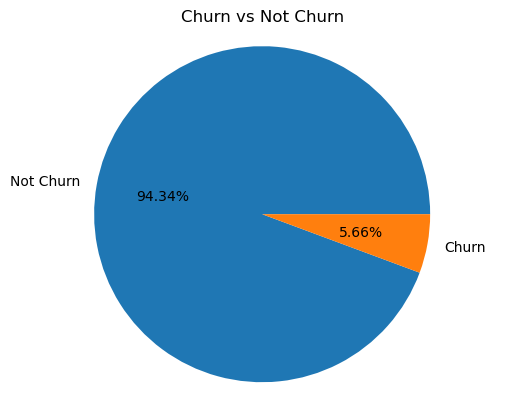

In [105]:
plt.pie(data['churn_probability'].value_counts().values,labels=['Not Churn','Churn'], autopct='%.2f%%')
plt.axis('equal')
plt.title('Churn vs Not Churn')
plt.show()

#### <span style="color:blue">Observation :-</span>
Only 5.5% of data has churn related information hence class imbalance handling techniques to be used

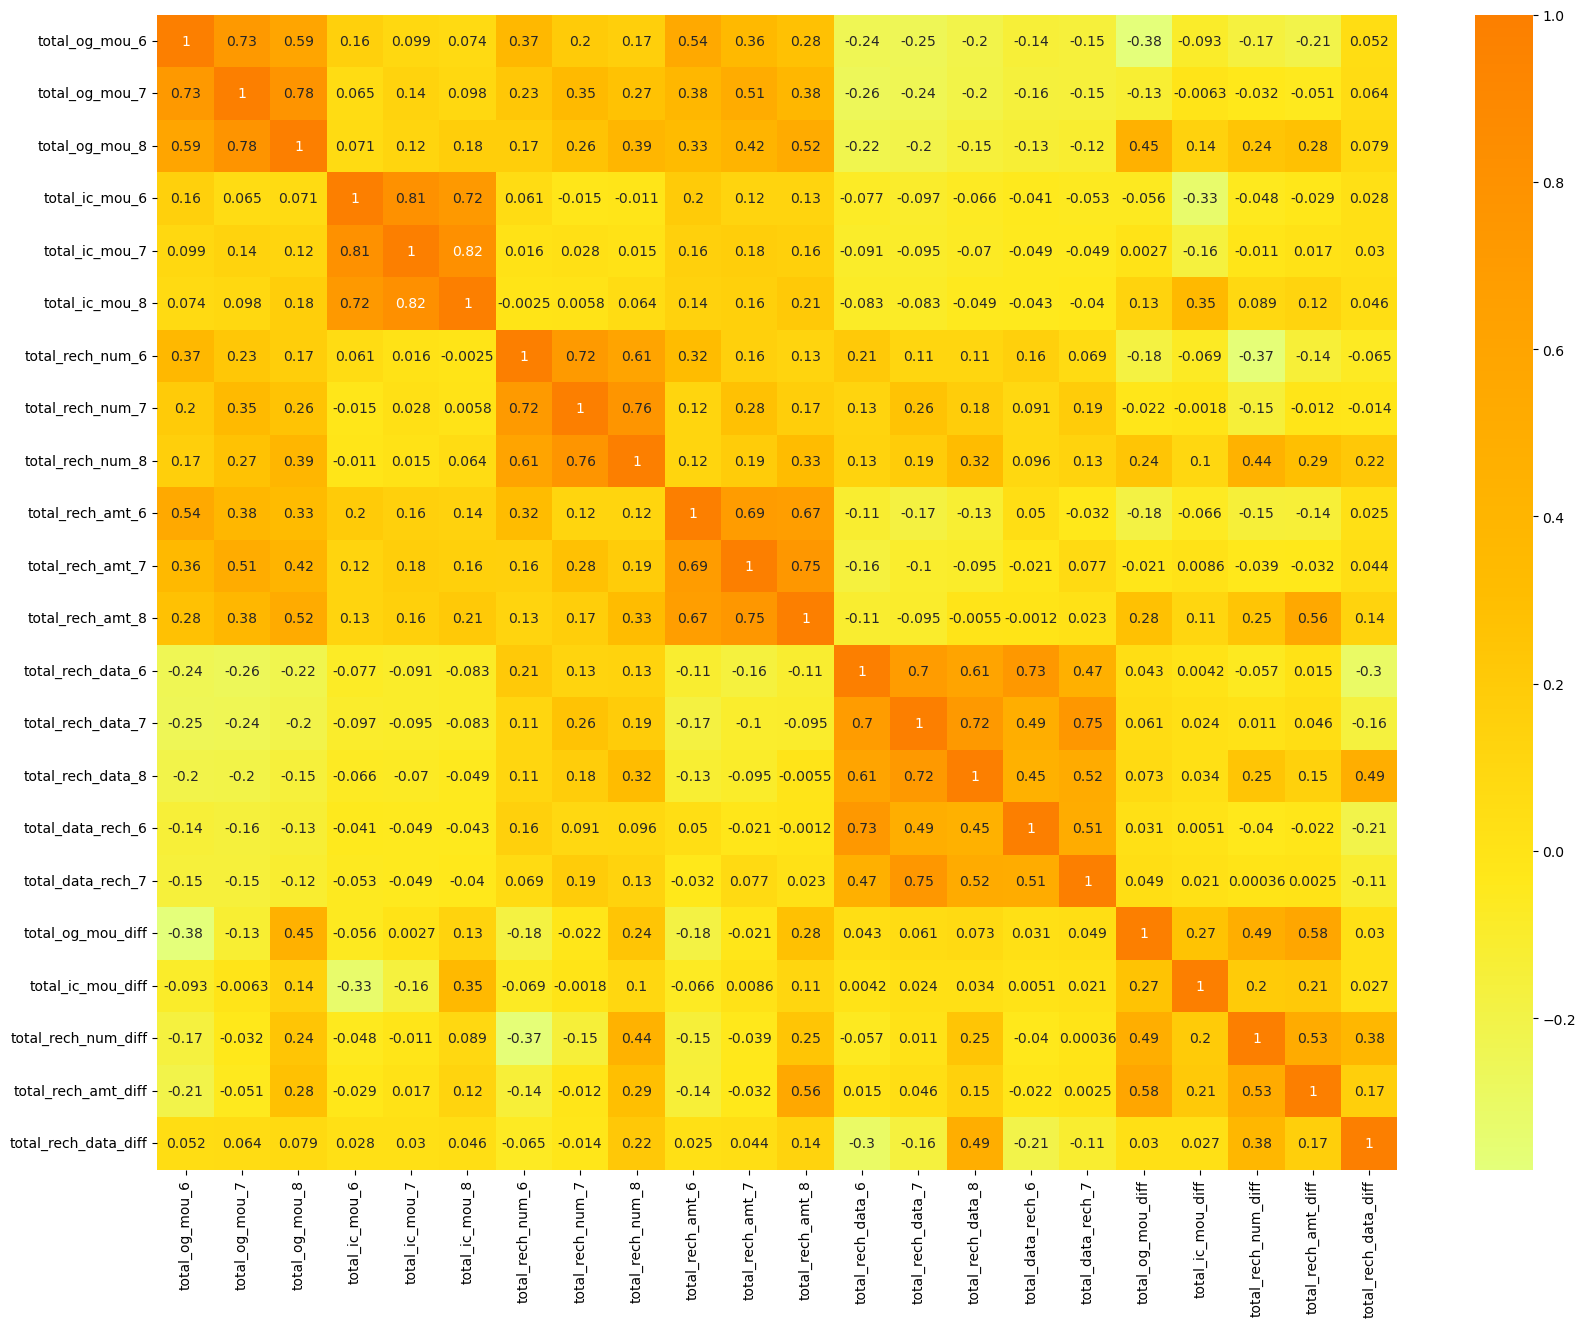

In [106]:
# Get all unique prefixes from column names
month_columns = list(col for col in data.columns if 'total' in col)

# figure size
plt.figure(figsize=(20, 15))

# heatmap
sns.heatmap(data[month_columns].corr(), cmap="Wistia", annot=True)
plt.show()

### Drop month related columns which are highly correlated with total

In [107]:
correlation_matrix = data.corr()

# Set the correlation threshold (adjust as needed)
correlation_threshold = 0.90
total_columns = set(col for col in data.columns if 'total' in col)
month_columns = set(col for col in data.columns if 'total' not in col and col.split('_')[-1] in ['6','7','8'])

# Find columns with high correlation
highly_correlated_columns = set()
for i in total_columns:
    for j in month_columns:
        if abs(correlation_matrix[i][j]) > correlation_threshold:
            print(i," ---- ",j," --- ",correlation_matrix[i][j])
            highly_correlated_columns.add(j)

# 'highly_correlated_columns' now contains the names of columns with high correlation

data.drop(columns=highly_correlated_columns, inplace=True)

total_ic_mou_6  ----  loc_ic_mou_6  ---  0.9000896722098638
total_rech_data_8  ----  count_rech_2g_8  ---  0.9040371536121776
total_data_rech_7  ----  amt_data_7  ---  0.9356310397351689
total_rech_amt_7  ----  arpu_7  ---  0.9506839420009429
total_rech_data_7  ----  sachet_2g_7  ---  0.9065152767346135
total_rech_data_7  ----  count_rech_2g_7  ---  0.9125010903570824
total_rech_amt_6  ----  arpu_6  ---  0.9425492243946277
total_data_rech_6  ----  amt_data_6  ---  0.9212365969179289
total_rech_amt_8  ----  arpu_8  ---  0.9580380715267289
total_rech_data_6  ----  sachet_2g_6  ---  0.9041657638058741
total_rech_data_6  ----  count_rech_2g_6  ---  0.9120673555658548


### Drop month related columns which are highly correlated

correlation_matrix = data.corr()

# Set the correlation threshold (adjust as needed)
correlation_threshold = 0.90
month_6 = set(col for col in data.columns if col.split('_')[-1] in ['6'])
month_7 = set(col for col in data.columns if col.split('_')[-1] in ['7'])
month_8 = set(col for col in data.columns if col.split('_')[-1] in ['8'])


# Find columns with high correlation
highly_correlated_columns = set()
for i in month_6:
    for j in month_6:
        if abs(correlation_matrix[i][j]) > correlation_threshold and i!=j:
            print(j," --- ",correlation_matrix[i][j])
            highly_correlated_columns.add(j)
for i in month_7:
    for j in month_7:
        if abs(correlation_matrix[i][j]) > correlation_threshold and i!=j:
            print(j," --- ",correlation_matrix[i][j])
            highly_correlated_columns.add(j)
for i in month_8:
    for j in month_8:
        if abs(correlation_matrix[i][j]) > correlation_threshold and i!=j:
            print(j," --- ",correlation_matrix[i][j])
            highly_correlated_columns.add(j)            

# 'highly_correlated_columns' now contains the names of columns with high correlation

data.drop(columns=highly_correlated_columns, inplace=True)

In [108]:
correlation_matrix = data.corr()

# Set the correlation threshold (adjust as needed)
correlation_threshold = 0.90
#month_columns = set(col for col in data.columns if 'total' not in col and col.split('_')[-1] in ['6','7','8'])

# Find columns with high correlation
highly_correlated_columns = set()
for i in data.columns:
    for j in data.columns:
        if abs(correlation_matrix[i][j]) > correlation_threshold and i!=j:
            print(i," ----- ",j," --- ",correlation_matrix[i][j])
            highly_correlated_columns.add(j)

# 'highly_correlated_columns' now contains the names of columns with high correlation

# data.drop(columns=highly_correlated_columns, inplace=True)

isd_og_mou_6  -----  isd_og_mou_7  ---  0.95864567937512
isd_og_mou_6  -----  isd_og_mou_8  ---  0.9615372125206182
isd_og_mou_7  -----  isd_og_mou_6  ---  0.95864567937512
isd_og_mou_7  -----  isd_og_mou_8  ---  0.9643444863731083
isd_og_mou_8  -----  isd_og_mou_6  ---  0.9615372125206182
isd_og_mou_8  -----  isd_og_mou_7  ---  0.9643444863731083
arpu_3g_6  -----  arpu_2g_6  ---  0.9309644371667695
arpu_3g_7  -----  arpu_2g_7  ---  0.9346120499295558
arpu_3g_8  -----  arpu_2g_8  ---  0.933966001455346
arpu_2g_6  -----  arpu_3g_6  ---  0.9309644371667695
arpu_2g_7  -----  arpu_3g_7  ---  0.9346120499295558
arpu_2g_8  -----  arpu_3g_8  ---  0.933966001455346
fb_user_6  -----  data_rechange_6  ---  -0.9208242144235644
fb_user_7  -----  data_rechange_7  ---  -0.9137025767772684
data_rechange_6  -----  fb_user_6  ---  -0.9208242144235644
data_rechange_7  -----  fb_user_7  ---  -0.9137025767772684
std_og_mou_diff  -----  total_og_mou_diff  ---  0.9052410814224976
total_og_mou_diff  -----  s

In [109]:
# fb_user is correlated to data recharge hence fb_user column can be droppped
del data['fb_user_6']
del data['fb_user_7']

# std_og_mou_diff is correlated to total_og_mou_diff hence std_og_mou_diff column can be droppped
del data['std_og_mou_diff']

# isd_og_mou_* all months are highl correlated to each other
del data['isd_og_mou_6']
del data['isd_og_mou_7']

# arpu_3g is correlated to arpu_2g
del data['arpu_3g_6']
del data['arpu_3g_7']
del data['arpu_3g_8']

In [110]:
eda_data = data.copy()

In [111]:
def count_plot(title, x_axis, data):
    print(data[x_axis].value_counts())
    plt.figure(figsize=[12,4])
    ax=sns.countplot(data=data,x=x_axis,hue="churn_probability")
    ax.set_title(title)
    plt.show()
    

total_rech_amt_group_6
>500_Recharges        4487
>200-300_Recharges    1675
100-200_Recharges     1284
<=100_Recharges        428
No_Recharge            240
Name: count, dtype: int64


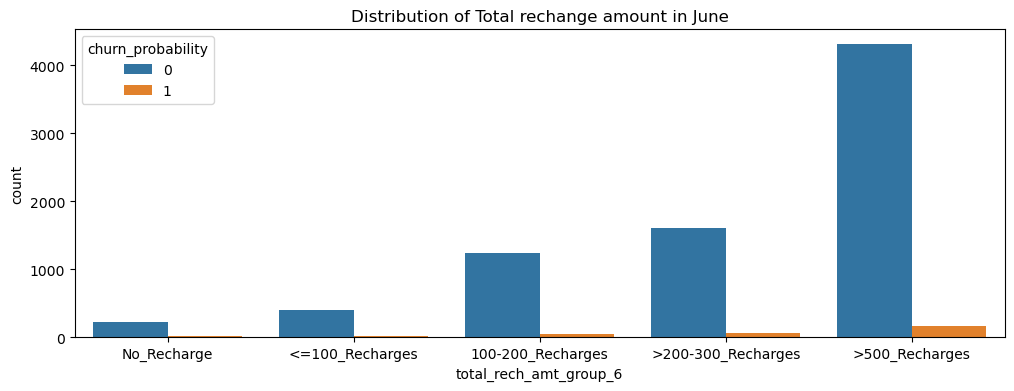

total_rech_amt_group_7
>500_Recharges        4468
>200-300_Recharges    1701
100-200_Recharges     1193
<=100_Recharges        441
No_Recharge            292
Name: count, dtype: int64


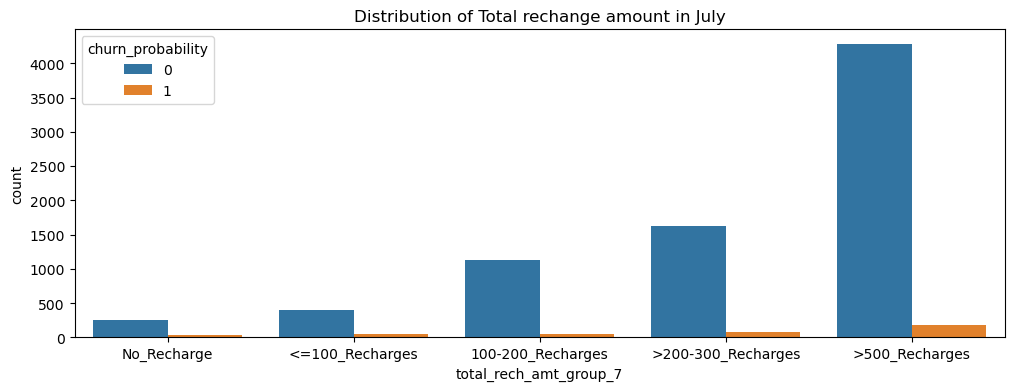

total_rech_amt_group_8
>500_Recharges        4181
>200-300_Recharges    2031
100-200_Recharges     1759
<=100_Recharges        962
No_Recharge            916
Name: count, dtype: int64


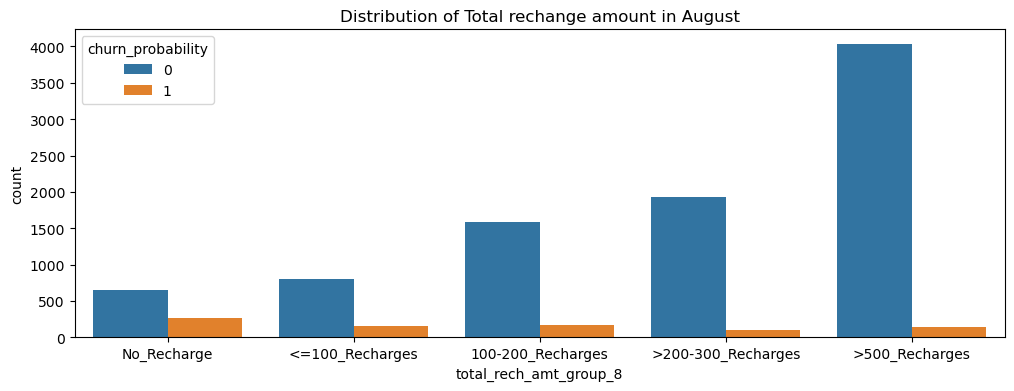

In [112]:
eda_data['total_rech_amt_group_6']=pd.cut(data['total_rech_amt_6'],[-1,0,100,200,300,500],labels=["No_Recharge","<=100_Recharges","100-200_Recharges",">200-300_Recharges",">500_Recharges"])
eda_data['total_rech_amt_group_7']=pd.cut(data['total_rech_amt_7'],[-1,0,100,200,300,500],labels=["No_Recharge","<=100_Recharges","100-200_Recharges",">200-300_Recharges",">500_Recharges"])
eda_data['total_rech_amt_group_8']=pd.cut(data['total_rech_amt_8'],[-1,0,100,200,300,500],labels=["No_Recharge","<=100_Recharges","100-200_Recharges",">200-300_Recharges",">500_Recharges"])

count_plot("Distribution of Total rechange amount in June", "total_rech_amt_group_6", eda_data)
count_plot("Distribution of Total rechange amount in July", "total_rech_amt_group_7", eda_data)
count_plot("Distribution of Total rechange amount in August", "total_rech_amt_group_8", eda_data)


#### <span style="color:blue">Observation :-</span>
<span style="color:blue">As the number of recharge amount increases, the churn rate decreases clearly.</span>

In [113]:
def plot_box_chart(attribute):
    plt.figure(figsize=(16,8))
    df = data
    plt.subplot(2,3,1)
    sns.boxplot(data=df, y=attribute+"_6",x="churn_probability",hue="churn_probability",
                showfliers=False,palette=("husl"))
    plt.subplot(2,3,2)
    sns.boxplot(data=df, y=attribute+"_7",x="churn_probability",hue="churn_probability",
                showfliers=False,palette=("husl"))
    plt.subplot(2,3,3)
    sns.boxplot(data=df, y=attribute+"_8",x="churn_probability",hue="churn_probability",
                showfliers=False,palette=("husl"))
    plt.show()

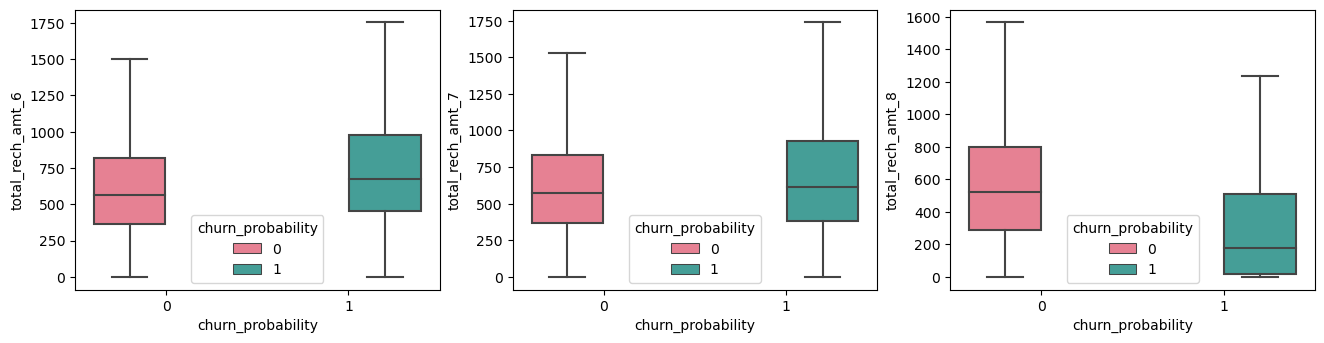

In [114]:
plot_box_chart('total_rech_amt')

#### <span style="color:blue">Observation :-</span>
<span style="color:blue">In the 8th month (Action Phase), we observe a decline in the total recharge amount for customers who have churned.</span>

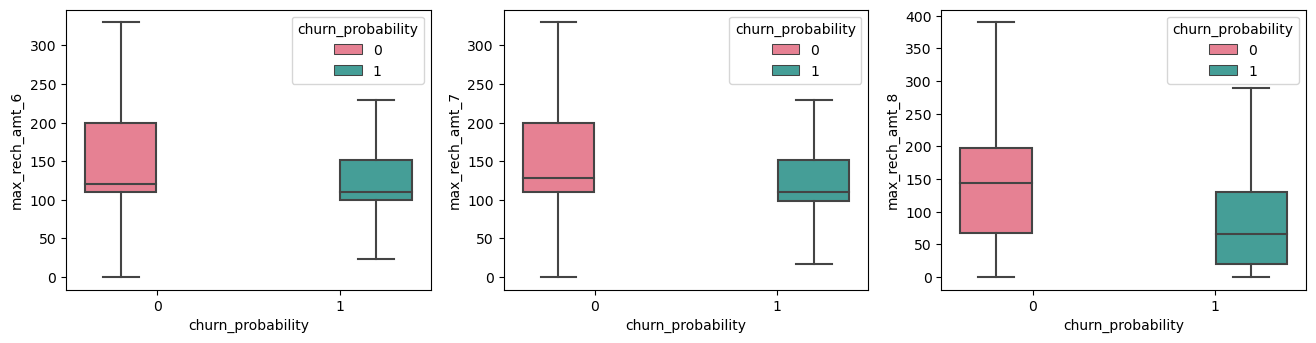

In [115]:
plot_box_chart('max_rech_amt')

#### <span style="color:blue">Observation :-</span>
<span style="color:blue">In the 8th month (Action Phase), we observe a decline in the maximum recharge amount for customers who have churned.</span>

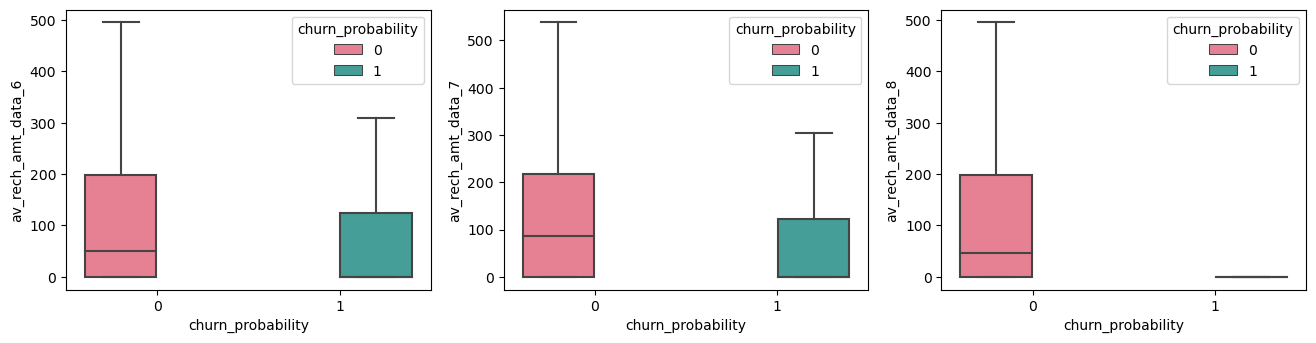

In [116]:
plot_box_chart('av_rech_amt_data')

#### <span style="color:blue">Observation :-</span>
<span style="color:blue">In the 8th month (Action Phase), we observe a decline in the average recharge amount data for customers who have churned.</span>

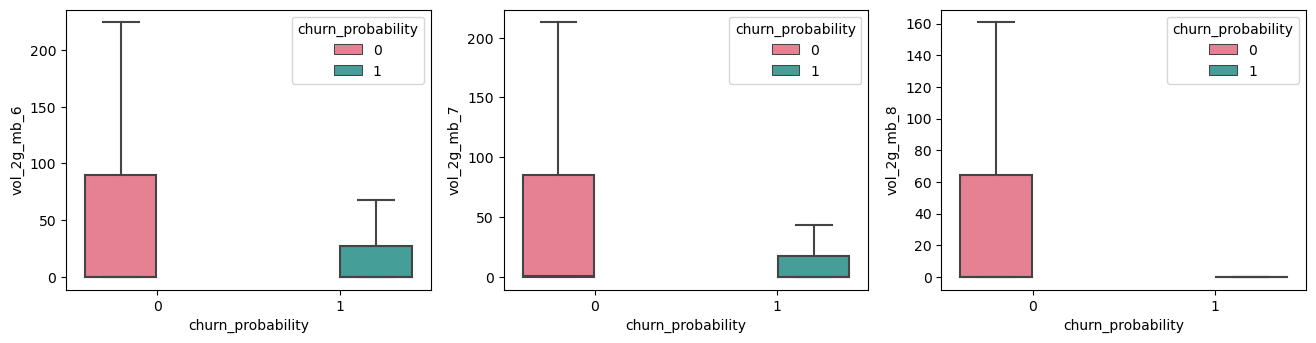

In [117]:
plot_box_chart('vol_2g_mb')

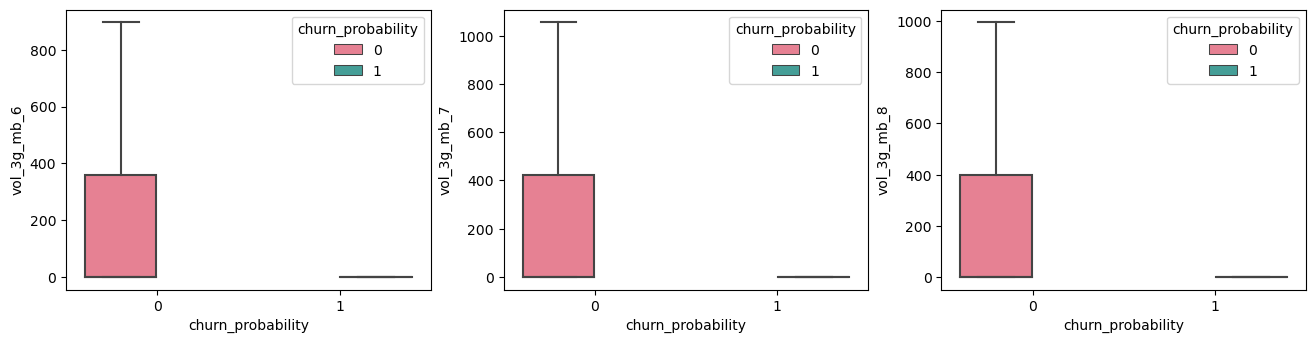

In [118]:
plot_box_chart('vol_3g_mb')

#### <span style="color:blue">Observation :-</span>
<span style="color:blue">In the 8th month, there is a decrease in 2G and 3G usage for customers who have churned.
Additionally, it is observed that non-churned customers tend to have higher 2G/3G usage, suggesting that churned customers may be located in areas where 2G/3G services are less accessible or reliable.</span>

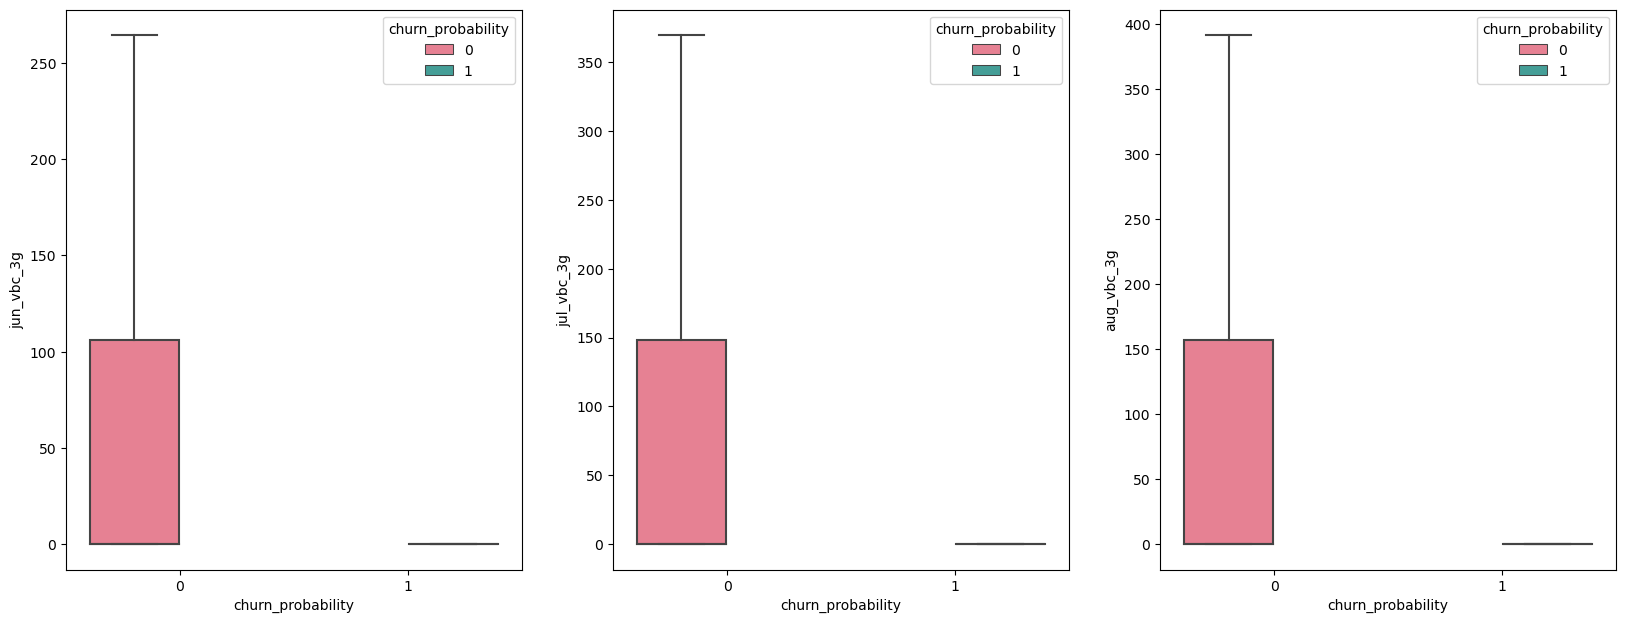

In [119]:

plt.figure(figsize=(20,16))
df = data
plt.subplot(2,3,1)
sns.boxplot(data=df, y="jun_vbc_3g",x="churn_probability",hue="churn_probability",
            showfliers=False,palette=("husl"))
plt.subplot(2,3,2)
sns.boxplot(data=df, y="jul_vbc_3g",x="churn_probability",hue="churn_probability",
            showfliers=False,palette=("husl"))
plt.subplot(2,3,3)
sns.boxplot(data=df, y="aug_vbc_3g",x="churn_probability",hue="churn_probability",
            showfliers=False,palette=("husl"))
plt.show()

We cannot make any observation so we will calculate the mean and will observe data

In [120]:
vbc_user = data.columns[data.columns.str.contains('vbc_3g',regex=True)]
vbc_user.tolist()

['aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g']

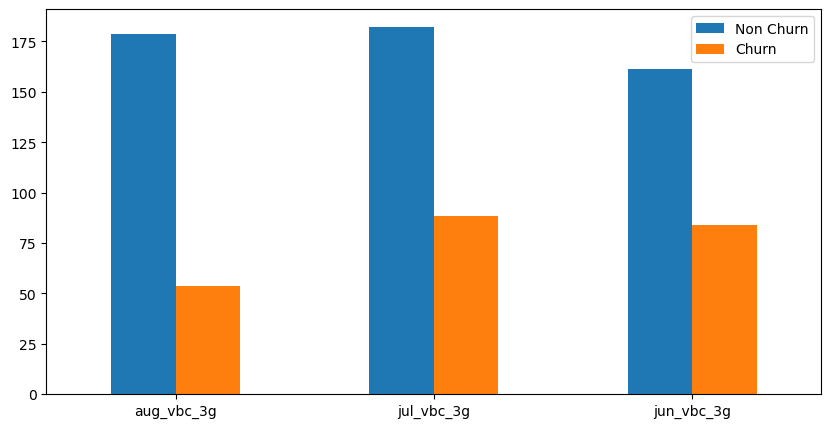

In [121]:
df =  data.copy()
columns_list = vbc_user
df_0 = df[df.churn_probability==0].filter(columns_list)
df_1 = df[df.churn_probability==1].filter(columns_list)
df_0
# mean_df_0 = pd.DataFrame([df_0.mean()],index={'Non Churn'})
mean_df_0= pd.DataFrame([df_0.mean()], index=['Non Churn'])
mean_df_1 = pd.DataFrame([df_1.mean()],index=['Churn'])

frames = [mean_df_0, mean_df_1]
mean_bar = pd.concat(frames)

mean_bar.T.plot.bar(figsize=(10,5),rot=0)
plt.show()


#### <span style="color:blue">Observation :-</span>
<span style="color:blue">"It's notable that the volume-based cost (VBC) for 3G services is considerably lower for Churned customers compared to Non-Churned Customers. Additionally, there is a decline in VBC during the 8th month.".</span>

total_rech_data_group_6
<=10_Recharges     10618
No_Recharge         8931
10-25_Recharges      387
>25_Recharges         14
Name: count, dtype: int64


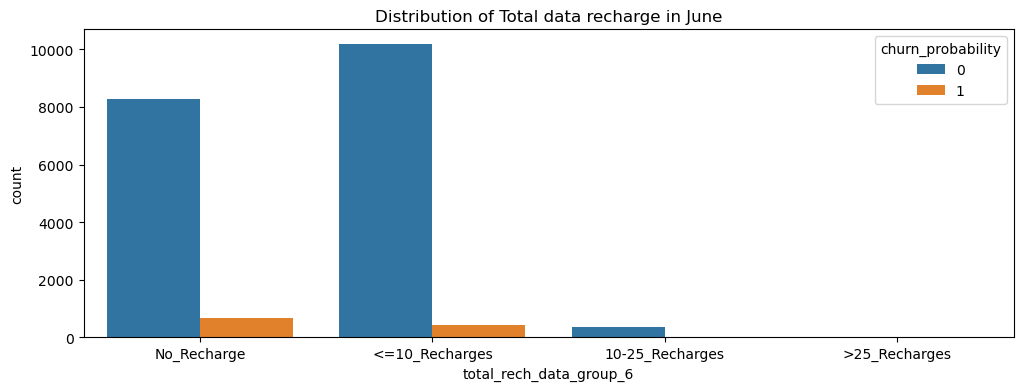

total_rech_data_group_7
<=10_Recharges     10831
No_Recharge         8611
10-25_Recharges      482
>25_Recharges         26
Name: count, dtype: int64


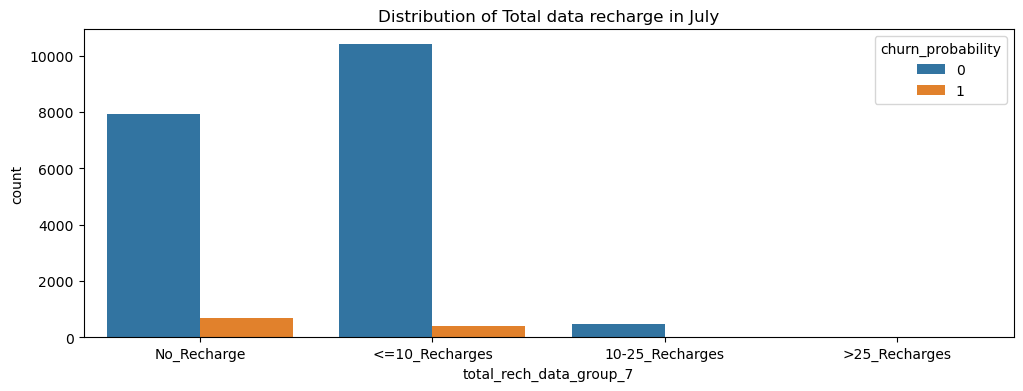

total_rech_data_group_8
<=10_Recharges     10373
No_Recharge         9139
10-25_Recharges      408
>25_Recharges         30
Name: count, dtype: int64


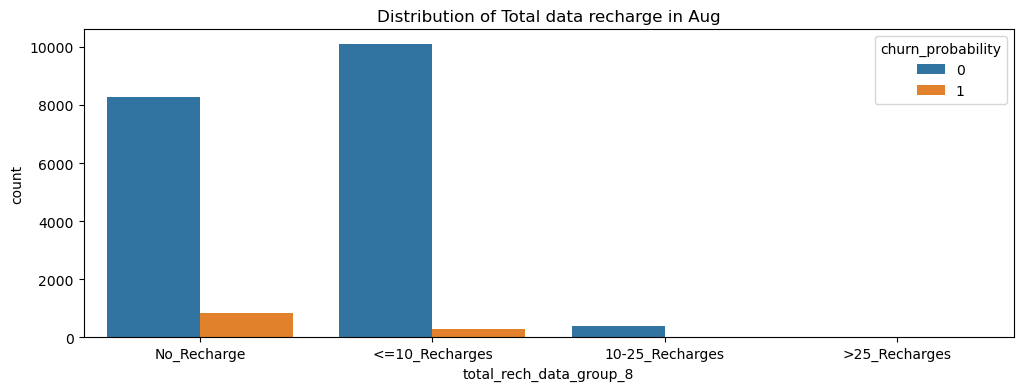

In [122]:
eda_data['total_rech_data_group_6']=pd.cut(data['total_rech_data_6'],[-1,0,10,25,100],labels=["No_Recharge","<=10_Recharges","10-25_Recharges",">25_Recharges"])
eda_data['total_rech_data_group_7']=pd.cut(data['total_rech_data_7'],[-1,0,10,25,100],labels=["No_Recharge","<=10_Recharges","10-25_Recharges",">25_Recharges"])
eda_data['total_rech_data_group_8']=pd.cut(data['total_rech_data_8'],[-1,0,10,25,100],labels=["No_Recharge","<=10_Recharges","10-25_Recharges",">25_Recharges"])

eda_data['total_rech_num_group_6']=pd.cut(data['total_rech_num_6'],[-1,0,10,25,1000],labels=["No_Recharge","<=10_Recharges","10-25_Recharges",">25_Recharges"])
eda_data['total_rech_num_group_7']=pd.cut(data['total_rech_num_7'],[-1,0,10,25,1000],labels=["No_Recharge","<=10_Recharges","10-25_Recharges",">25_Recharges"])
eda_data['total_rech_num_group_8']=pd.cut(data['total_rech_num_8'],[-1,0,10,25,1000],labels=["No_Recharge","<=10_Recharges","10-25_Recharges",">25_Recharges"])


count_plot("Distribution of Total data recharge in June","total_rech_data_group_6",eda_data)
count_plot("Distribution of Total data recharge in July","total_rech_data_group_7",eda_data)
count_plot("Distribution of Total data recharge in Aug","total_rech_data_group_8",eda_data)

#### <span style="color:blue">Observation :-</span>
<span style="color:blue">Churn rate is more incase of no or less rechange</span>

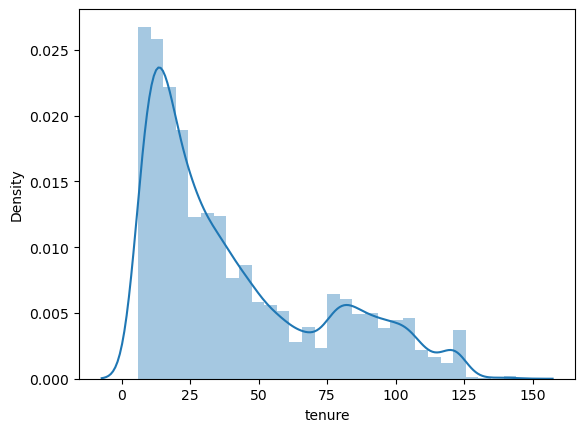

In [123]:
# Let's create a new variable called 'tenure' based on the number of months ('aon' divided by 30) and rounding to the nearest month.
data['tenure'] = (data['aon']/30).round(0)
unseen['tenure'] = (data['aon']/30).round(0)
# Now that we've derived the 'tenure' column from 'aon', we can safely drop it
data.drop('aon',axis=1, inplace=True)

# To better visualize the distribution of the 'tenure' variable, we can plot it.

sns.distplot(data['tenure'],bins=30)
plt.show()

<Figure size 1200x700 with 0 Axes>

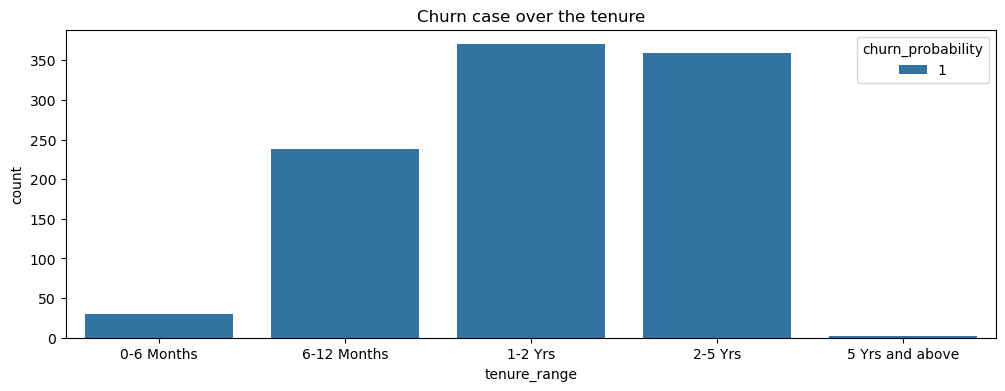

In [124]:
# created a range and divided it in different category
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
eda_data['tenure_range'] = pd.cut(data['tenure'], tn_range, labels=tn_label)
# Plotting a bar plot for tenure range
plt.figure(figsize=[12,7])
churn_data = eda_data[eda_data['churn_probability'] ==1]
plt.figure(figsize=[12,4])
ax=sns.countplot(data=churn_data,x='tenure_range',hue="churn_probability")
ax.set_title("Churn case over the tenure")
plt.show()

#### <span style="color:blue">Observation :-</span>
<span style="color:blue">People churn more between 1st and 2nd year</span>

# 2. Create X, y

Lets create X and y datasets and skip "circle_id" since it has only 1 unique value

In [125]:
y = data.pop('churn_probability')
X = data

X.shape, y.shape

((19950, 158), (19950,))

Splitting train and test data to avoid any contamination of the test data

## 5. Preprocessing

### 5.1 Handling outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [126]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [127]:
#X = X.apply(cap_outliers, axis=0)
# Removing 5% of outliers
for col in X.select_dtypes(include=['float64', 'int64']).columns:
    lower_limit = X[col].quantile(0.05)
    upper_limit = X[col].quantile(0.95)
    
    X.loc[X[col] <= lower_limit, col] = lower_limit
    X.loc[X[col] >= upper_limit, col] = upper_limit


### 5.2 Feature scaling

Lets also scale the features by scaling them with Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [128]:
def scale_data(X):
    scaler = StandardScaler()
    X_col = X.columns
    X_scaled = scaler.fit_transform(X)
    X_scale_final = pd.DataFrame(X_scaled, columns=X_col)
    print("Scaling the data ....")
    return X_scale_final, scaler

### 5.3 Train Test split

In [129]:
def train_test_data(X,Y,train_size=0.7,test_size=0.3):    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, train_size=train_size, random_state=42)
    return X_train, X_test, y_train, y_test

### 5.4 Class imbalance fix (SMOTE)

In [130]:
def resampling_data(X_train, y_train) :
   
    print("Shape of train datatset before : "+str(X_train.shape))
    print("Percenatge of Churned customer data : "+str(round(100*y_train.sum()/len(y_train),2)))
    print("Applying SMOTE to normalize imbalance ....")

    #Initializing SMOTE: Synthetic Minority Over-sampling Technique
    # using this as data is skewed 
    smote = SMOTE(random_state=42)
    X_tr,y_tr = smote.fit_resample(X_train,y_train)
    print("Shape of train datatset after SMOTE : "+str(X_tr.shape))
    return X_tr,y_tr

### 5.5 PCA implementation

In [131]:
def no_of_component_through_pca(X_train) :
    pca = PCA(0.9)
    df_train_pca = pca.fit_transform(X_train)
    return df_train_pca.shape[1]
    

In [132]:
def incremental_pca(X_train, X_test, feature_number):
    pca = IncrementalPCA(n_components=feature_number)    
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca, pca

### 5.6 process data before Model creation

In [133]:
X.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Index: 19950 entries, 4 to 69997
Data columns (total 158 columns):
 #    Column                 Dtype  
---   ------                 -----  
 0    onnet_mou_6            float64
 1    onnet_mou_7            float64
 2    onnet_mou_8            float64
 3    offnet_mou_6           float64
 4    offnet_mou_7           float64
 5    offnet_mou_8           float64
 6    roam_ic_mou_6          float64
 7    roam_ic_mou_7          float64
 8    roam_ic_mou_8          float64
 9    roam_og_mou_6          float64
 10   roam_og_mou_7          float64
 11   roam_og_mou_8          float64
 12   loc_og_t2t_mou_6       float64
 13   loc_og_t2t_mou_7       float64
 14   loc_og_t2t_mou_8       float64
 15   loc_og_t2m_mou_6       float64
 16   loc_og_t2m_mou_7       float64
 17   loc_og_t2m_mou_8       float64
 18   loc_og_t2f_mou_6       float64
 19   loc_og_t2f_mou_7       float64
 20   loc_og_t2f_mou_8       float64
 21   loc_og_t2c_mou_6       float64
 22   l

In [134]:
X_scaled, scaler = scale_data(X)
X_train, X_test, y_train, y_test = train_test_data(X_scaled, y)
X_train_resample, y_train_resample = resampling_data(X_train, y_train)
no_of_component = no_of_component_through_pca(X_train_resample)
X_train_pca, X_test_pca, pca = incremental_pca(X_train_resample, X_test, no_of_component)
X_train_pca.shape

Scaling the data ....
Shape of train datatset before : (13965, 158)
Percenatge of Churned customer data : 5.65
Applying SMOTE to normalize imbalance ....
Shape of train datatset after SMOTE : (26352, 158)


(26352, 52)

# Model Creation

### Model Matrics summary

In [135]:
def plot_confusion_matrix(cm):
    """
    This function prints and plots the confusion matrix.
    """
    classes=[0,1]
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def print_model_metrics(y_test,y_pred,model_name):
    print(model_name+" Model Stats Scores Summary : ")
    cp = confusion_matrix(y_test,y_pred)
    plt.figure()
    plot_confusion_matrix(cp)
    plt.show()
    accuracy = round(accuracy_score(y_test,y_pred),2)
    recall = round(recall_score(y_test,y_pred),2)
    precision = round(precision_score(y_test,y_pred),2)
    auc = round(roc_auc_score(y_test,y_pred),2)
    f1 = round(f1_score(y_test,y_pred),2)

    data = [[model_name,accuracy,recall,precision,auc,f1]] 
    df = pd.DataFrame(data, columns = ['Model', 'Accuracy','Precision','Recall','AUC','F1'])
    return df 

## 6.1. Logistic Regression with PCA

In [136]:
lr = LogisticRegression(random_state=42)

model_train = lr.fit(X_train_pca, y_train_resample)
pred_probs_train = model_train.predict_proba(X_train_pca)[:,1]
print("Linear Regression Accurancy train : "+"{:2.2}".format(metrics.roc_auc_score(y_train_resample, pred_probs_train)))

pred_probs_test = model_train.predict_proba(X_test_pca)[:,1]
print("Linear Regression Accurancy test : "+"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test)))

Linear Regression Accurancy train : 0.92
Linear Regression Accurancy test : 0.87


## 6.2. Random Forest

### GridSearch to fetch best parameters for Random forest

In [137]:
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')
param_grid = {
    'n_estimators': [20, 30, 50, 70], 
    'max_depth': [20, 30, 40],
    'min_samples_leaf':[100,200,300]
}
# Create GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model to the data
grid_search.fit(X_train_pca, y_train_resample)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Use the best model to make predictions
best_model = grid_search.best_estimator_

In [138]:
print('Best parameters')
best_params

Best parameters


{'max_depth': 40, 'min_samples_leaf': 100, 'n_estimators': 70}

In [139]:
rfc = RandomForestClassifier(class_weight='balanced', random_state=42, max_depth=best_params['max_depth'], n_estimators=best_params['n_estimators'], min_samples_leaf= best_params['min_samples_leaf'] )
rfc.fit(X_train_pca,y_train_resample)

RandomForestClassifier(class_weight='balanced', max_depth=40,
                       min_samples_leaf=100, n_estimators=70, random_state=42)

In [140]:
result = pd.DataFrame()

RandomForest Train Model Stats Scores Summary : 


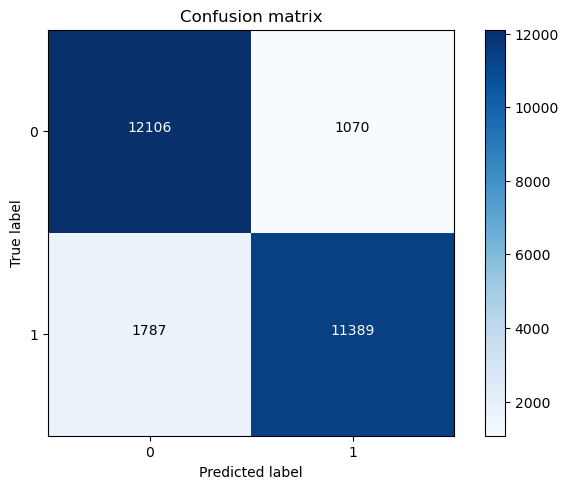

,Model,Accuracy,Precision,Recall,AUC,F1
0,RandomForest Train,0.89,0.86,0.91,0.89,0.89


In [141]:
train_predictions = rfc.predict(X_train_pca)
train = print_model_metrics(y_train_resample,train_predictions,"RandomForest Train")
result = train
train

RandomForest Test Model Stats Scores Summary : 


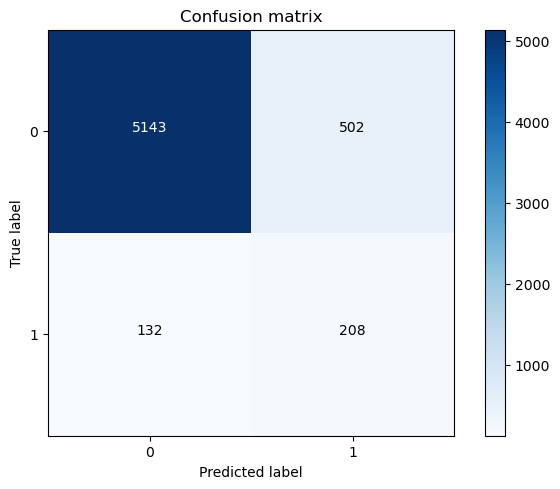

,Model,Accuracy,Precision,Recall,AUC,F1
0,RandomForest Test,0.89,0.61,0.29,0.76,0.4


In [142]:
test_predictions = rfc.predict(X_test_pca)
test =  print_model_metrics(y_test,test_predictions,"RandomForest Test")
result = pd.concat([result, test], ignore_index=True)
test

In [143]:
result

,Model,Accuracy,Precision,Recall,AUC,F1
0,RandomForest Train,0.89,0.86,0.91,0.89,0.89
1,RandomForest Test,0.89,0.61,0.29,0.76,0.40


## 6.3. XGBoost

In [144]:
# hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 5

# specify range of hyperparameters
param_grid = {#'gamma': [10, 20, 50],
              'learning_rate': [0.1, 0.2, 0.3],
              'max_depth': [ 4, 5], 
              'min_child_weight': [25, 50],
              'n_estimators': [100]}          


# specify model
xgb_model = XGBClassifier(random_state=42, n_jobs=-1)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'accuracy', # accuracy
                        cv = folds, 
                        n_jobs = -1,
                        verbose = 1,
                        return_train_score=True) 

In [145]:
model_cv.fit(X_train_pca, y_train_resample)  

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [4, 5],
                         'min_child_weight': [25, 50], 'n_estimators': [100]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [146]:
print('Best parameters')
model_cv.best_params_

Best parameters


{'learning_rate': 0.3,
 'max_depth': 5,
 'min_child_weight': 25,
 'n_estimators': 100}

In [147]:
model = XGBClassifier(random_state=42, min_child_weight=model_cv.best_params_['min_child_weight'],n_estimators=model_cv.best_params_['n_estimators'],learning_rate=model_cv.best_params_['learning_rate'], max_depth=model_cv.best_params_['max_depth'])
model.fit(X_train_pca, y_train_resample)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=25, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

XGBoost Train Model Stats Scores Summary : 


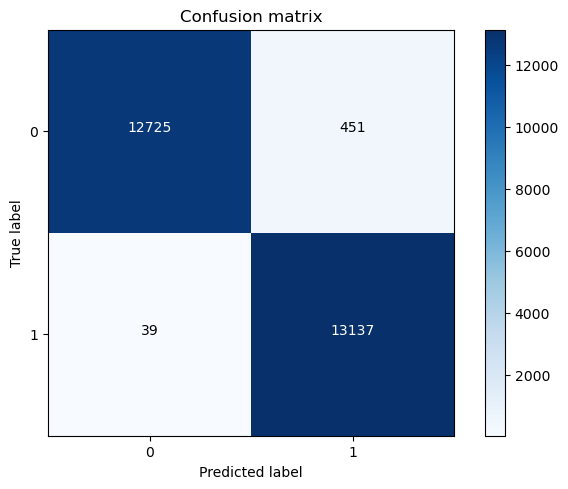

,Model,Accuracy,Precision,Recall,AUC,F1
0,XGBoost Train,0.98,1.0,0.97,0.98,0.98


In [148]:
y_pred_train = model.predict(X_train_pca)
train = print_model_metrics(y_train_resample, y_pred_train ,'XGBoost Train')
result = pd.concat([result, train], ignore_index=True)
train

XGBoost Test Model Stats Scores Summary : 


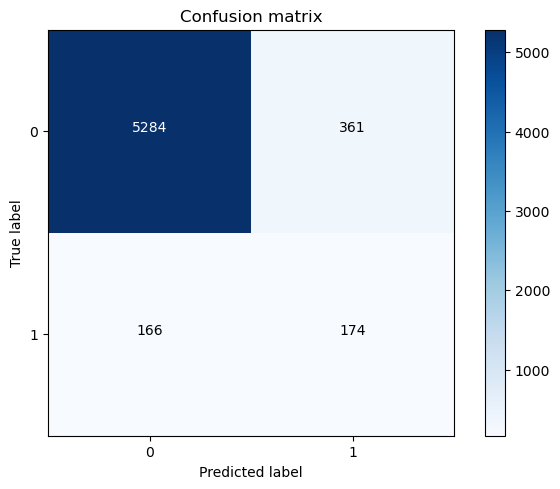

,Model,Accuracy,Precision,Recall,AUC,F1
0,XGBoost Test,0.91,0.51,0.33,0.72,0.4


In [149]:

y_pred_test = model.predict(X_test_pca)
test = print_model_metrics(y_test, y_pred_test ,'XGBoost Test')
result = pd.concat([result, test], ignore_index=True)
test

In [150]:
col = list(X_scaled.columns)
df_pca = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'PC3':pca.components_[2],'Feature':col})
df_pca.head(15)

,PC1,PC2,PC3,Feature
0,0.141729,0.060469,-0.003834,onnet_mou_6
1,0.119747,0.087094,0.050661,onnet_mou_7
2,0.041018,0.121466,0.134768,onnet_mou_8
3,0.094793,0.115155,-0.075936,offnet_mou_6
4,0.075645,0.143270,-0.008372,offnet_mou_7
5,-0.002050,0.167140,0.088660,offnet_mou_8
6,0.000054,0.000029,0.022112,roam_ic_mou_6
7,0.037000,-0.032014,-0.026796,roam_ic_mou_7
8,0.048383,-0.015009,-0.031820,roam_ic_mou_8
9,0.013249,-0.003139,0.036570,roam_og_mou_6


In [151]:
result

,Model,Accuracy,Precision,Recall,AUC,F1
0,RandomForest Train,0.89,0.86,0.91,0.89,0.89
1,RandomForest Test,0.89,0.61,0.29,0.76,0.40
2,XGBoost Train,0.98,1.00,0.97,0.98,0.98
3,XGBoost Test,0.91,0.51,0.33,0.72,0.40


In [152]:
print("predict - ",y_pred_test.sum())
print("predict - ",y_test.sum())

predict -  535
predict -  340


In [153]:
y_test.sum()

340

# Conclusion
- Since XGBboost is performing better on train data hence same would be used on test data


# 7. Creating submission file

In [154]:
unseen_new = unseen.set_index('id')[X_train.columns]

In [155]:
# Impute missing values
imp = SimpleImputer(strategy='constant', fill_value=0)
X_unseen_imputed = imp.fit_transform(unseen_new)
X_unseen_scaled = scaler.transform(X_unseen_imputed)
X_unseen_pca = pca.transform(X_unseen_scaled)
X_unseen_pca.shape

(30000, 52)

In [156]:
unseen['churn_probability'] = model.predict(X_unseen_pca)
output = unseen[['id','churn_probability']]
output.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


In [157]:
output.to_csv('submission.csv',index=False)

In [158]:
output['churn_probability'].value_counts()

churn_probability
0    26736
1     3264
Name: count, dtype: int64

## Recommend strategies to manage customer churn based on our observations

* Since a <b>decline in various recharge-related metrics</b> is observed in the 8th month for customers who have churned, concentrate on retaining customers during this critical phase. Offer <b>targeted promotions, discounts, or loyalty rewards</b> to encourage them to stay.

* Relation between <b>total recharge amount and churn rate</b>, introduce attractive recharge and top-up offers. These <b>offers can incentivize customers</b> to continue using your services.

* The <b>total usage of 2g and 3g increases</b>, the churn rate decreases. Invest in <b>improving and expanding your data services</b> to meet the growing demand for mobile internet. Ensure a seamless data experience for your customers.


* Customers tend to <b>churn more in the first 0-6 months of their tenure. Implement proactive onboarding and engagement strategies for new customers</b> to make their initial experience with your services positive and engaging

* <b>Leverage customer segmentation and behavior data</b> to tailor offers and retention programs. Not all customers have the same needs and preferences, so personalized strategies can be more effective

* <b>Create custom tariff plans</b> that align with the usage patterns and preferences of customers in <b>areas with poor 2G/3G coverage.</b> These plans should offer attractive pricing and services.

* Invest in network infrastructure upgrades to enhance the availability and <b>reliability of 2G and 3G services in areas where churned customers are more prevalent</b>. This can improve the overall customer experience.
